   # Using Time Series to Predict Finanial Endowment 

*This is a toy example for me to get acquianted with time series and presenting with Jupyter Notebooks, thus the prediction is not meant to be accurate by any measure. Expect a very introductory presentation, as this is my first foray into forecasting time series.*

## Extract Data
For the data to be analysed, I chose the financial endwoment of a few British univiersities as listed on [Wikipedia](https://en.wikipedia.org/wiki/List_of_UK_universities_by_endowment).  The data is *very* limited, and I don't suppose that one can accurately predict the future endwoment only based on this data, but it may be a fun learning experience.

Here I go.

### Import the necessary modules

In [1]:
from collections import OrderedDict
import datetime

# Parsing
from bs4 import BeautifulSoup
import requests
# Plotting
import matplotlib.pyplot as plt
# Numerical computation
import pandas as pd
import numpy as np
# Predicting 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

### Extract the 2nd table on the Wikipedia page:

In [2]:
#I'm interested in the 2nd table on the page
table_number = 2 

url = "http://en.wikipedia.org/wiki/List_of_UK_universities_by_endowment"
soup = BeautifulSoup(requests.get(url).text, "html.parser")
table = soup.find_all('table', class_="wikitable")[table_number - 1] # 0-indexed structures

### Create a dictionary to store the data from the table

The dictionary format is such that the key is the university name, and the value is a list of strings indicating their annual endowment.

In [3]:
# Using `OrderedDict()` to have the legend ordered later on when plotting the results 
unis = OrderedDict()
for row in table.find_all('tr')[1:]:
    data = row.text.split('\n')
    unis[data[1]] = [money.split('[')[0] for money in data[2:-1]]

### Plot all the data in the dictionary

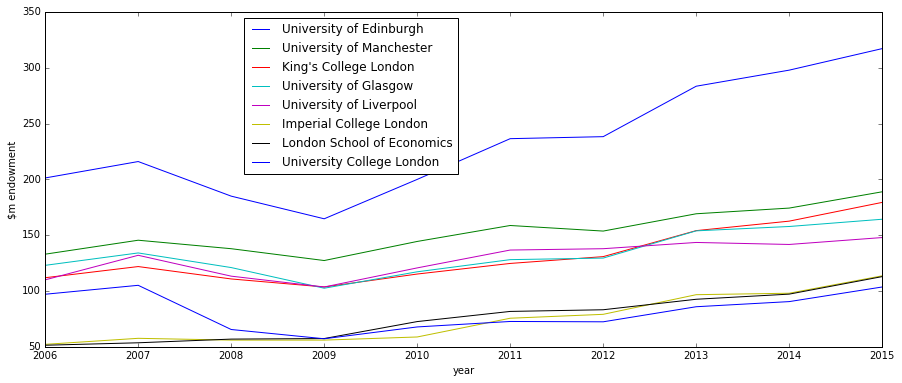

In [4]:
years = list(range(2015, 2005, -1)) # Values are stored in reverse chronological order 
for uni, money in unis.items():
    y = [m[1:] for i, m in enumerate(money)] # first character of `m` is `$`
    plt.figure(num=1, figsize=(15,6))
    plt.plot(years, y, label=uni)

plt.legend(unis.keys(), bbox_to_anchor=(0.5, 1),)
plt.xlabel('year')
plt.ylabel('$m endowment')

# Don't format the years in scientific notation 
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

# Extract values for prediction and pre-process data

This should be easily extended to predict multiple series, but I'll use only one here for (my) clarity. 

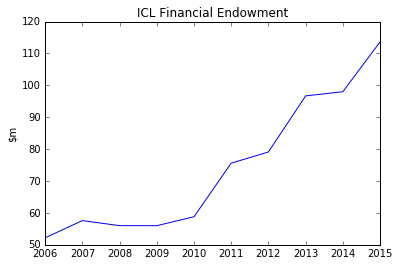

In [5]:
# Convert to `datetime` objects for the time series processing
date = [datetime.datetime.strptime(str(year), "%Y") for year in years]
df = pd.DataFrame({'ICL': [float(val[1:]) for val in unis["Imperial College London"]], "Year": date})
df = df.set_index("Year")
ts = df["ICL"][::-1]

plt.plot(ts)
plt.title("ICL Financial Endowment")
plt.ylabel("$m")
plt.show()

### Eliminating Trend

#### What?
Now, time series often have two properties that are best eliminated before attempting any predicting algorithm: trend and seasonality:
- **Trend** refers to an overall tendancy that the data follows. For instance, the endwoment seems to increase over time in the data above.
- **Seasonality** refers to a predictable phenomenon that affects the data regularly. No seasonality for the data above,  but think for example an increase in knitwear sales every winter.

#### Why?
To my undestanding, there are simply more practical tools and theoretical background developed around **stationary** series (i.e. series without trend or seasonality aka series with stationary mean, variance, and autocorrelation).

#### How?

There are 2 how's:
- How do I tell if the data is stationary?

When you cannot tell from the plot, you may calculate the degree of stationarity using [Dickey-Fuller Test](https://en.wikipedia.org/wiki/Dickey–Fuller_test).

- How do I make the data stationary?

There are many methods, but here I'll use [**differencing**](https://en.wikipedia.org/wiki/Data_differencing) because it seems to be effective and simple enough for an introduction tutorial.

##### Differencing
Differencing is a simple process that extracts the relative difference between any ~~two~~ number of adjacent instances, and for this case the number will be 2. Be aware that this means that the first instance will be invalid as there is no previous instance to subtract.

Year
2006-01-01     52.2
2007-01-01     57.6
2008-01-01     56.0
2009-01-01     56.0
2010-01-01     58.8
2011-01-01     75.6
2012-01-01     79.1
2013-01-01     96.7
2014-01-01     98.0
2015-01-01    113.6
Name: ICL, dtype: float64


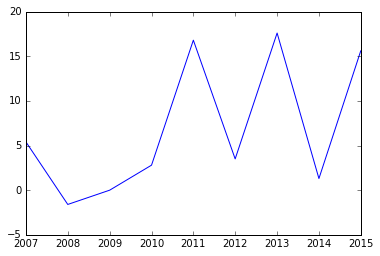

In [6]:
ts_diff = ts - ts.shift()
#Drop the invalid instances (i.e. the first one)
ts_diff.dropna(inplace=True)
print(ts) #Print original values
plt.plot(ts_diff) 
# Plot the differences
plt.show()

## Training a Predictor

The time series above does not show a trend anymore and seems quite stationary (visually, at least). The next step is to use Auto-Regressive Integrated Moving Averages (ARIMA) to forecast the time series.

### Auto-Regressive Terms

**Lag:** In time series analysis, "lag" is a way to refer to previous values of a variable. For example, you may predict a new value based on `p` past values (lags). 

Auto-Regressive terms (**AR**IMA) are just the number of lags used for predicting a new value. So if there are 5 auto-regressive terms, then the new value is dependent on 5 past terms.

### Moving Average Terms

**Moving average** refers to a technique to calculate the trend of the data. It chooses a time window and averages the values inside that time window to smooth out the noise. For a visual interpretation, check the graph below.

Moving Average terms (ARI**MA**) are lagged errors used for predicting a new value. So if there are 5 moving average terms, each term is also predicted by 5 errors calculated as the difference between the moving average value at that instance and the actual value.

### How to calculate the terms?

To decide on what values the terms should take, one may use techniques such as Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF), but there is very little data in this example, so I will simply pick both to be `1`.

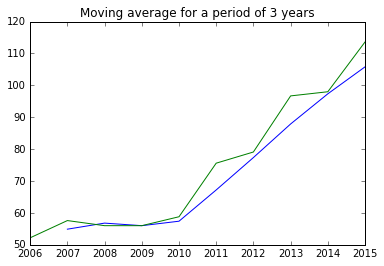

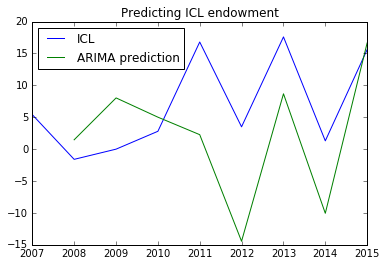

In [7]:
moving_avg = pd.rolling_mean(ts,2)
plt.plot(moving_avg)
plt.plot(ts)
plt.title('Moving average for a period of 3 years')
plt.show()

# Helper function
def plot_graphs(series1, series2, label1="ICL", label2="ARIMA prediction", title="Predicting ICL endowment"):
    plt.plot(series1, label=label1)
    plt.plot(series2, label=label2)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()
    
model = ARIMA(ts_diff, order=(1,1,1))
results_ARIMA = model.fit(disp=-1)  
plot_graphs(ts_diff, results_ARIMA.fittedvalues)

## Visualising the results

Above, it can be seen that although the ARIMA predictions catch some of the peaks, it underestimates quite a bit at times -- for instance, the actual results are rarely ever negative, while the predictions go as low as `-15`.

Keep in mind that at this point, the plot only displays the difference between each instance. To visualise the actual results, one needs to scale back the results:

/usr/lib/python3.5/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


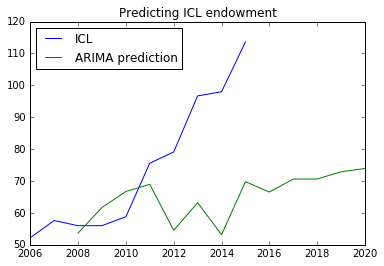

In [8]:
preds = results_ARIMA.predict(end=13).cumsum() + ts.ix[0]

plot_graphs(ts,preds)

## Discussion

In my defense, this is my first time doing time series analysis. I would suppose that this is far from enough data to get good results, but the results may also be bad because it predicted negative differences previously, thus the values have a harder time picking up. To confirm this, I will plot the unscaled predictions: 

/usr/lib/python3.5/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


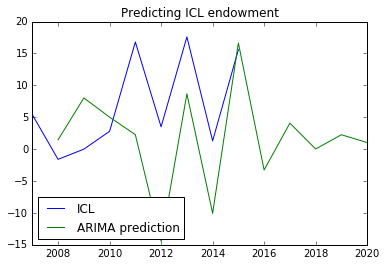

In [9]:
plot_graphs(ts_diff, results_ARIMA.predict(end=13))

## Improving results

To improve the results I will try running ARIMA with different parameters, and predict on the non-stationary series.

### No AR terms, 2 MA terms:

/usr/lib/python3.5/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


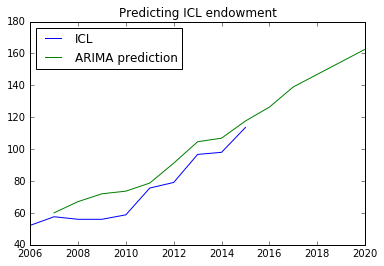

In [10]:
results_ARIMA = ARIMA(ts_diff, order=(0, 0, 2)).fit(disp=-1)
preds = results_ARIMA.predict(end=13).cumsum() + ts.ix[0]
plot_graphs(ts,preds)

### Predicting on non-stationary series:

/usr/lib/python3.5/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


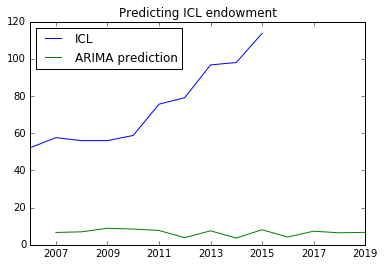

In [11]:
results_ARIMA = ARIMA(ts, order=(1, 1, 0)).fit(disp=-1)
preds = results_ARIMA.predict(end=13)
plot_graphs(ts,preds)

## Conclusions

To obtain better results, I believe there's a need for more training data, and a better understanding of the domain -- in this case, better understanding of how ARIMA works and how to tune the parameters would probably help.

The experiment however was successful in the sense that it provided me with an interesting hands-on introduction to time series and using Jupyter Notebooks as a presentation medium.